# Data Mining Project 
Developed by Gil Teixeira, 88194.

The paper selected is named:
### Analyzing the Performance of Stroke Prediction using ML Classification Algorithms [1]

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
print("Using pandas %s version" % pd.__version__)
print("Using numpy %s version" % np.__version__)
print("Using sklearn %s version" % sk.__version__)
print("Using imblearn %s version" % imblearn.__version__)



Using pandas 1.3.4 version
Using numpy 1.20.3 version
Using sklearn 1.0.2 version
Using imblearn 0.9.0 version


## Index

* 1 - [Pre-processing](#11)
    * 1.1 - [Cleaning and encoding](#11)
    * 1.2 - [Handling imbalanced data](#12)
* 2 - [Machine Learning Algorithm Models](#21)
    * 2.1 - [Logistic Regression](#21)
    * 2.2 - [Decision Tree](#22)
    * 2.3 - [Random Fores](#23)
    * 2.4 - [K-Nearest-Neighbors](#24)
    * 2.5 - [SVM](#25)
    * 2.6 - [Naive Bayes](#26)
* 3 - [Results](#31)



<a name="11"></a>
First the data must be PreProcessed!
We drop the id column as it doesn't make any diference for the models performance.
Then we must substitute NaN (null) entries with the class means in this case, as pointed by the paper, exclusively the column bmi.
Finally we must encode the 5 non-numerical variables to numeric ones!

In [2]:
dataset = pd.read_csv('./dataset/healthcare-dataset-stroke-data.csv')
df_dataset = pd.DataFrame(data=dataset)

#Dropping 'id' column
df_dataset.drop('id', axis=1, inplace=True)

#Substituting NaN (null) entries with the bmi means
df_dataset['bmi'].fillna(df_dataset['bmi'].mean(), inplace=True)
categoric_vars = ["gender","ever_married","work_type","Residence_type","smoking_status"]
#Encoding of non-numerical variables!
for categoric_var in categoric_vars:
    df_dataset[categoric_var].replace({label: int(idx) for idx, label in enumerate(np.unique(df_dataset[categoric_var]))}, inplace=True)

print(df_dataset.head())

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   
2       1  80.0             0              1             1          2   
3       0  49.0             0              0             1          2   
4       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level        bmi  smoking_status  stroke  
0               1             228.69  36.600000               1       1  
1               0             202.21  28.893237               2       1  
2               0             105.92  32.500000               2       1  
3               1             171.23  34.400000               3       1  
4               0             174.12  24.000000               2       1  


<a name="12"></a>
### The big imbalance
As noted by the authors the data is highly imbalanced!
As shown in the plot bellow there are way more entries for no risk of stroke then for having risk of one. Of the 5110 entries only 249 correspond to patients with risk of stroke!
The paper suggest to under-sample the 'no rist' to match the amount of 'risk' entries. 
In this notebook we will also expolore over-sampling the 'risk' entries to match the 'no risk' ones! This might be advantageous as more information is passed about the data set while not having a huge bias twoards 'no risk'.

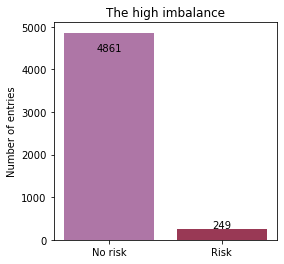

In [3]:
def plot_imbalance(dataset):
        no_risk_count = dataset["stroke"].loc[dataset["stroke"] == 0].count()
        risk_count = dataset["stroke"].loc[dataset["stroke"] == 1].count()
        bar_data = [no_risk_count, risk_count]
        plt.figure(figsize=(4,4))
        bar_plot = plt.bar(["No risk", "Risk"], bar_data, color=['#AE76A6', '#993955'])
        for idx,rect in enumerate(bar_plot):
                height = rect.get_height()
                plt.text(rect.get_x() + rect.get_width()/2., 0.9*height,
                        bar_data[idx],
                        ha='center', va='bottom', rotation=0)
        plt.title("The high imbalance")
        plt.ylabel("Number of entries")
        plt.show()
plot_imbalance(df_dataset)

To handle this imbalance and as not to produce models with very high accuracy but with very poor results in other very important metrics that will be used to compare the multiple models addressed!
The technique used in the paper references '7 Techniques to Handle Imbalanced Data – Kdnuggets' and the majority class is under-sampled to match the minority class.
Over-sampling will also be performed to compare both!

After Under-sample:


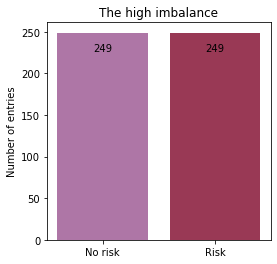

After Over-sample:


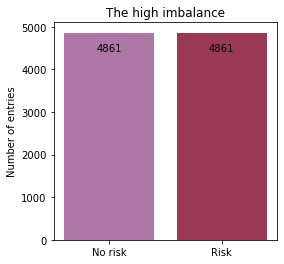

In [4]:
#Over-sampling
oversample = SMOTE()
over_x, over_y = oversample.fit_resample(df_dataset.drop(
    'stroke', axis=1), df_dataset['stroke'].astype('int') )
oversampled_data = over_x.join(over_y)

#Under-sampling
df_dataset.loc[df_dataset["stroke"] == 0] = df_dataset.loc[df_dataset["stroke"] == 0].sample(249)
df_dataset.dropna(inplace=True)
df_dataset.reset_index(drop=True, inplace=True)


print("After Under-sample:")
plot_imbalance(df_dataset)
print("After Over-sample:")
plot_imbalance(oversampled_data)


Since our prediction target is boolean it makes a lot of sense to try first the logistic regression!
The results for the multiple metrics throughout this notebook will change per each run since the train and test sets have different samples!
<a name="21"></a>

## Machine Learning Algorithm Models 
Before modeling we must separate our data intro training and testing data sets!
Furthermore some useful functions that will be reused by every model are defined here.
Moreover it's important to note that from now we will build every model for both uner and over-sampled data!

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_dataset.drop(
    'stroke', axis=1), df_dataset['stroke'].astype('int'), test_size=0.2)
over_x_train, over_x_test, over_y_train, over_y_test = train_test_split(over_x, over_y, test_size=0.2)
stats = {}
# useful functions for the model stats!


def print_stats(cls_name, y_test, prediction):
    print(cls_name + " metrics:")
    sample_type = cls_name.split(' ')[0]
    cls_name = ' '.join(cls_name.split(' ')[1:])
    print(sample_type)
    print(cls_name)

    if cls_name not in stats.keys():
        stats[cls_name] = {}
    stats[cls_name][sample_type] = {}
    stats[cls_name][sample_type] = {
        "accuracy":  metrics.accuracy_score(y_test, prediction),
        "precision":  metrics.average_precision_score(y_test, prediction),
        "recall":  metrics.recall_score(y_test, prediction),
        "f1_score": metrics.f1_score(y_test, prediction)
    }
    print("Accuracy: " + str(stats[cls_name][sample_type]["accuracy"]))
    print("Precision: " + str(stats[cls_name][sample_type]["precision"]))
    print("Recall: " + str(stats[cls_name][sample_type]["recall"]))
    print("F1 score: " + str(stats[cls_name][sample_type]["f1_score"]))


def show_roc_curve(cls, x_test, y_test):
    probs = cls.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("Receiver operating characteristic (ROC) curve:")
    metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()


### Logistic Regression
#### Under-sampling

Under-sampled Logistic Regression metrics:
Under-sampled
Logistic Regression
Accuracy: 0.73
Precision: 0.6722875816993463
Recall: 0.7647058823529411
F1 score: 0.7428571428571428
Receiver operating characteristic (ROC) curve:


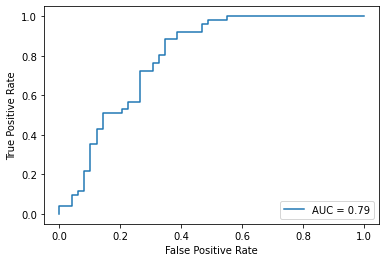

In [6]:
logistic_classifier = LogisticRegression(max_iter=1000)
under_log_model = logistic_classifier.fit(x_train, y_train)
under_prediction = logistic_classifier.predict(x_test)
print_stats("Under-sampled Logistic Regression", y_test, under_prediction)
show_roc_curve(under_log_model, x_test, y_test)

#### Over-sampling

Over-sampled Logistic Regression metrics:
Over-sampled
Logistic Regression
Accuracy: 0.7902313624678663
Precision: 0.7315356495598428
Recall: 0.7938775510204081
F1 score: 0.7922606924643586
Receiver operating characteristic (ROC) curve:


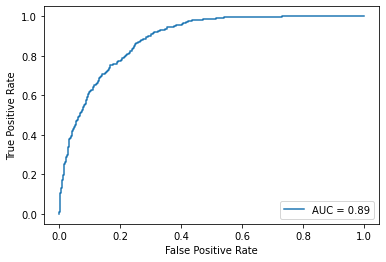

In [7]:
over_log_model = logistic_classifier.fit(over_x_train, over_y_train)
over_prediction = logistic_classifier.predict(over_x_test)
print_stats("Over-sampled Logistic Regression", over_y_test, over_prediction)
show_roc_curve(over_log_model, over_x_test, over_y_test)

<a name="22"></a>

### Decision Tree Classification
#### Under-sampling

Under-sampled Decision Tree metrics:
Under-sampled
Decision Tree
Accuracy: 0.73
Precision: 0.6702240896358543
Recall: 0.7843137254901961
F1 score: 0.7476635514018691
Receiver operating characteristic (ROC) curve:


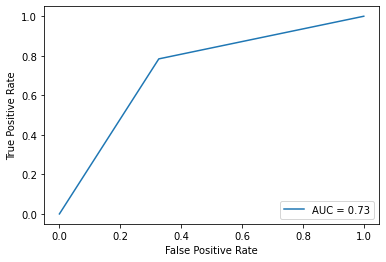

In [8]:
decision_tree_cls = tree.DecisionTreeClassifier()
under_decision_tree_model = decision_tree_cls.fit(x_train, y_train)
prediction = under_decision_tree_model.predict(x_test)
print_stats("Under-sampled Decision Tree", y_test, prediction)
show_roc_curve(under_decision_tree_model, x_test, y_test)

#### Over-sampling

Over-sampled Decision Tree metrics:
Over-sampled
Decision Tree
Accuracy: 0.9028277634961439
Precision: 0.8599724238974346
Recall: 0.9193877551020408
F1 score: 0.9050728277247615
Receiver operating characteristic (ROC) curve:


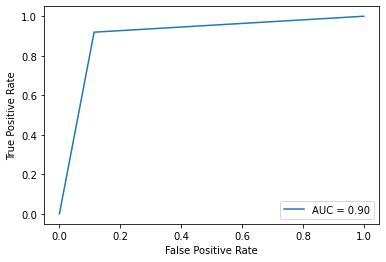

In [9]:
over_decision_tree_model = decision_tree_cls.fit(over_x_train, over_y_train)
prediction = under_decision_tree_model.predict(over_x_test)
print_stats("Over-sampled Decision Tree", over_y_test, prediction)
show_roc_curve(over_decision_tree_model, over_x_test, over_y_test)

<a name="23"></a>


### Random Forest Classification
#### Under-sampling

Under-sampled Random Forest metrics:
Under-sampled
Random Forest
Accuracy: 0.77
Precision: 0.7103848946986202
Recall: 0.803921568627451
F1 score: 0.780952380952381
Receiver operating characteristic (ROC) curve:


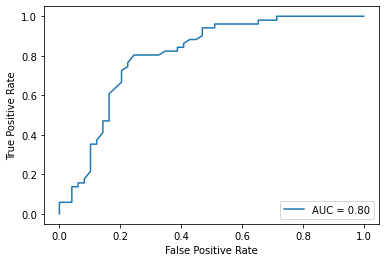

In [10]:
random_forest_cls = RandomForestClassifier()
under_random_forest_model = random_forest_cls.fit(x_train, y_train)
prediction = under_random_forest_model.predict(x_test)
print_stats("Under-sampled Random Forest", y_test, prediction)
show_roc_curve(under_random_forest_model, x_test, y_test)

#### Over-sampling

Over-sampled Random Forest metrics:
Over-sampled
Random Forest
Accuracy: 0.9403598971722366
Precision: 0.9087479805318186
Recall: 0.9571428571428572
F1 score: 0.9417670682730924
Receiver operating characteristic (ROC) curve:


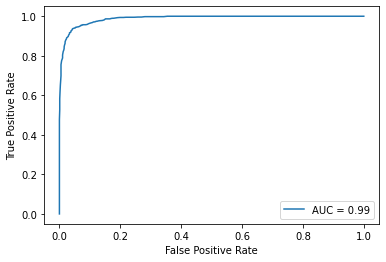

In [11]:
over_random_forest_model = random_forest_cls.fit(over_x_train, over_y_train)
prediction = over_random_forest_model.predict(over_x_test)
print_stats("Over-sampled Random Forest", over_y_test, prediction)
show_roc_curve(over_random_forest_model, over_x_test, over_y_test)

Like the Decision Tree model the Random Forest one behaves way better with over-sampling! 
<a name="24"></a>

### K-nearest neighbors
#### Under-sampling

Under-sampled K-nearest neighbors metrics:
Under-sampled
K-nearest neighbors
Accuracy: 0.71
Precision: 0.6525630252100839
Recall: 0.7647058823529411
F1 score: 0.7289719626168223
Receiver operating characteristic (ROC) curve:


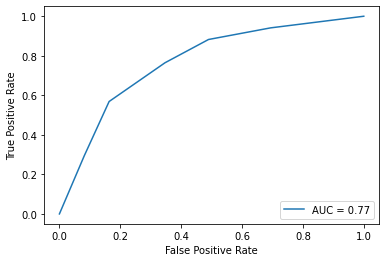

In [12]:
k_nearest_neighbors_cls = KNeighborsClassifier()
under_k_nearest_neighbors_model = k_nearest_neighbors_cls.fit(x_train, y_train)
prediction = under_k_nearest_neighbors_model.predict(x_test)
print_stats("Under-sampled K-nearest neighbors", y_test, prediction)
show_roc_curve(under_k_nearest_neighbors_model, x_test, y_test)

#### Over-Sampling

Over-sampled K-nearest neighbors metrics:
Over-sampled
K-nearest neighbors
Accuracy: 0.900771208226221
Precision: 0.8388136639687476
Recall: 0.9857142857142858
F1 score: 0.9091764705882353
Receiver operating characteristic (ROC) curve:


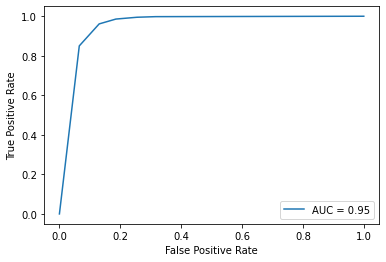

In [13]:
over_k_nearest_neighbors_model = k_nearest_neighbors_cls.fit(over_x_train, over_y_train)
prediction = over_k_nearest_neighbors_model.predict(over_x_test)
print_stats("Over-sampled K-nearest neighbors", over_y_test, prediction)
show_roc_curve(over_k_nearest_neighbors_model, over_x_test, over_y_test)

<a name="25"></a>

### Support Vector Machine

Under-sampled SVM metrics:
Under-sampled
SVM
Accuracy: 0.71
Precision: 0.6525630252100839
Recall: 0.7647058823529411
F1 score: 0.7289719626168223
Receiver operating characteristic (ROC) curve:


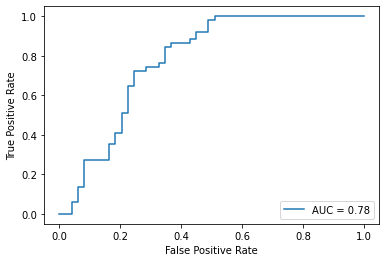

In [14]:
svm_cls = clf = SVC(kernel='rbf', probability=True)
under_svm_model = svm_cls.fit(x_train, y_train)
prediction = under_svm_model.predict(x_test)
print_stats("Under-sampled SVM", y_test, prediction)
show_roc_curve(under_svm_model, x_test, y_test)

#### Over-sampling

Over-sampled SVM metrics:
Over-sampled
SVM
Accuracy: 0.7686375321336761
Precision: 0.7051473358546702
Recall: 0.7989795918367347
F1 score: 0.7767857142857143
Receiver operating characteristic (ROC) curve:


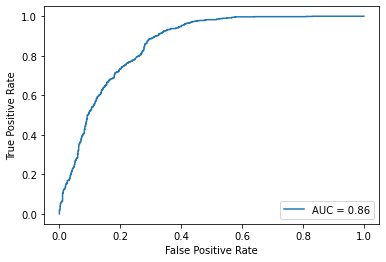

In [15]:
over_svm_model = svm_cls.fit(over_x_train, over_y_train)
prediction = over_svm_model.predict(over_x_test)
print_stats("Over-sampled SVM", over_y_test, prediction)
show_roc_curve(over_svm_model, over_x_test, over_y_test)

<a name="26"></a>

### Naive Bayes

Under-sampled Naive Bayes metrics:
Under-sampled
Naive Bayes
Accuracy: 0.72
Precision: 0.671055486024197
Recall: 0.6862745098039216
F1 score: 0.7142857142857144
Receiver operating characteristic (ROC) curve:


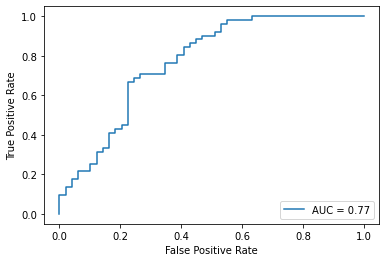

In [16]:
naive_bayes_cls = clf = GaussianNB()
under_naive_bayes_model = naive_bayes_cls.fit(x_train, y_train)
prediction = under_naive_bayes_model.predict(x_test)
print_stats("Under-sampled Naive Bayes", y_test, prediction)
show_roc_curve(under_naive_bayes_model, x_test, y_test)

#### Over-sampling

Over-sampled Naive Bayes metrics:
Over-sampled
Naive Bayes
Accuracy: 0.794344473007712
Precision: 0.7271121652423786
Recall: 0.8530612244897959
F1 score: 0.8069498069498069
Receiver operating characteristic (ROC) curve:


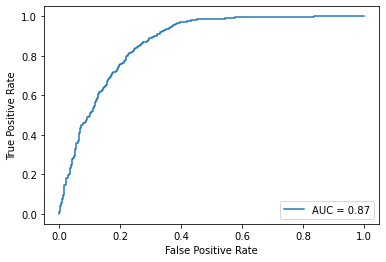

In [17]:
over_naive_bayes_model = naive_bayes_cls.fit(over_x_train, over_y_train)
prediction = over_naive_bayes_model.predict(over_x_test)
print_stats("Over-sampled Naive Bayes", over_y_test, prediction)
show_roc_curve(over_naive_bayes_model, over_x_test, over_y_test)

## Results
Following the tests done and with the statistcs already filled, the multiple metrics are compared in bar plots by the same order used before: accuracy, precision, recall and f1 score!
For each ML Algorithm Model we will have the over-sampled statistic, in a darker color, followed by the under-sampled statistic, in a lighter color, because, most of the time, the values will be higher for the over

In [18]:
def plot_stat(stat_name):
    colot_pallet1 = ["#e5571f", "#f0960f", "#8e00e6", "#2c83ba", "#43a863", "#e5ba10"]
    colot_pallet2 = ["#e57d25", "#f3ab3f", "#935ba4", "#3a96d1", "#4db86e", "#f2cf45"]
    stat_name_sorted_stats = dict(sorted(stats.items(),key=lambda item:item[1]["Over-sampled"][stat_name], reverse=True))
    plt.figure(figsize = (12, 8))
    X_axis = np.arange(len(stat_name_sorted_stats.keys()))
    over_stat_name_sorted_values = [item["Over-sampled"][stat_name]*100 for item in stat_name_sorted_stats.values()]
    under_stat_name_sorted_values = [item["Under-sampled"][stat_name]*100 for item in stat_name_sorted_stats.values()]
    bar_plot1 = plt.bar(X_axis - 0.2, over_stat_name_sorted_values, color=colot_pallet1, width=0.5) 
    bar_plot2 = plt.bar(X_axis + 0.2, under_stat_name_sorted_values, color=colot_pallet2, width=0.5) 
    for idx,rect in enumerate(bar_plot1):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 0.95*height,
            "{:.1f}%".format(over_stat_name_sorted_values[idx]),
            ha='center', va='bottom', rotation=0)

    for idx,rect in enumerate(bar_plot2):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 0.95*height,
            "{:.1f}%".format(under_stat_name_sorted_values[idx]),
            ha='center', va='bottom', rotation=0)
        
    plt.xticks(X_axis, stat_name_sorted_stats)
    plt.xlabel("ML Algorithm Models")
    plt.ylabel(stat_name.title() + " in %") 
    plt.title("Models ranked by " + stat_name + "!") 
    plt.show() 

This function serves to plot any stat!

### Accuracy

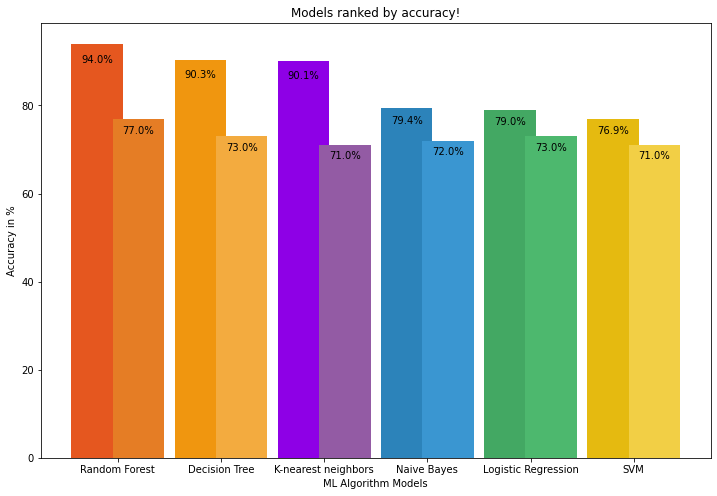

In [19]:
plot_stat("accuracy")


### Precision

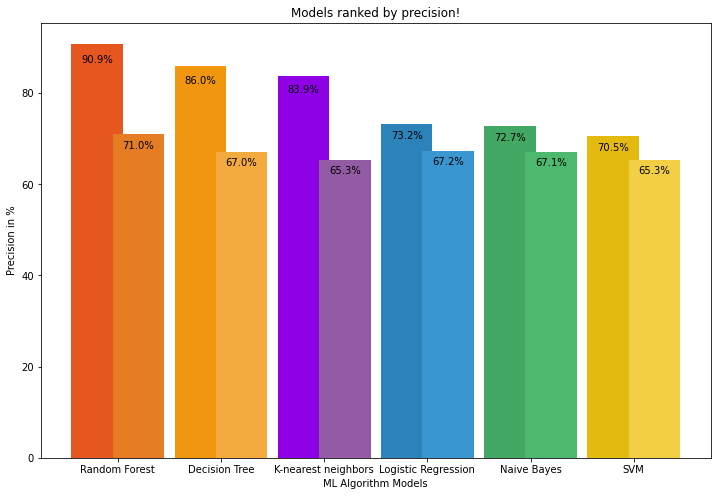

In [20]:
plot_stat("precision")

### Recall

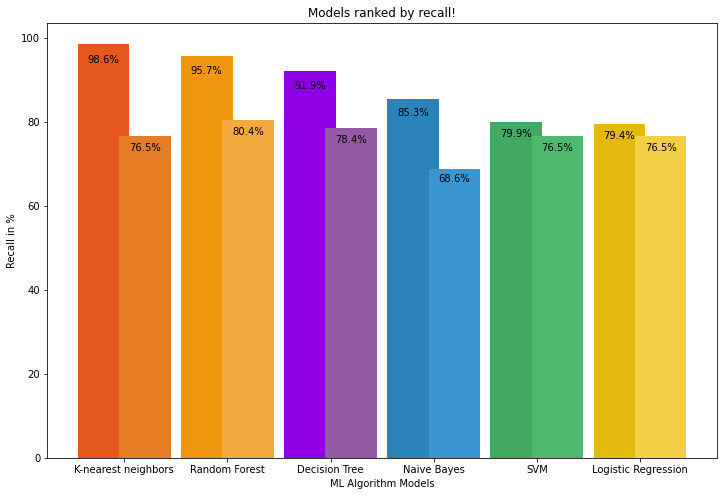

In [21]:
plot_stat("recall")

### F1 score

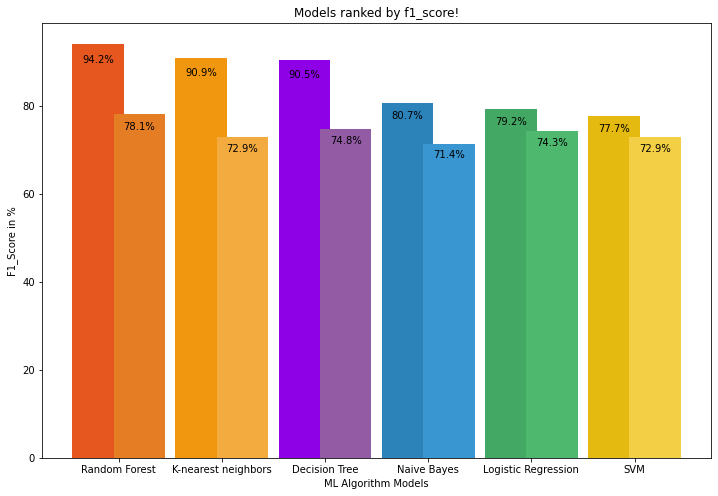

In [22]:
plot_stat("f1_score")

## Conclusions
The results differ very little from the ones suggested in the paper when using the under-sampling method to balance the data.
Using over-sampling yields, in general, better results tho ti might come at a cost since the computational effort for the model building is increased!
A ML algorithm trained on image datasets would probably lead to a better model for stroke prediction, though with some of these algorithms, on this dataset, we do get fairly good results! 

## References
[1] Accessed 20th of February, 2022 - https://thesai.org/Downloads/Volume12No6/Paper_62-Analyzing_the_Performance_of_Stroke_Prediction.pdf